Model the uncertain inflow energy
==========================
In this module, we prepare the time series model for the uncertain inflow energy $X_t$.

Whole model description:  
https://www2.isye.gatech.edu/people/faculty/Alex_Shapiro/Rep-Dec2011.pdf

In [1]:
import pandas
import numpy
# read historical data for the four reserviors
hist = [
    pandas.read_csv(
        "./data/hist_{}.csv".format(i), 
        sep=";",
        index_col=0,
    ) 
    for i in range(4)
]
# concatenate the data to fill missing value yearly
hist_all = pandas.concat(hist, axis=1, ignore_index=True)
hist_all.fillna(hist_all.mean(), inplace=True)
hist_all_log = numpy.log(hist_all)
# split the data back to individual reserviors
hist = [hist_all.iloc[:,12*i:12*(i+1)] for i in range(4)]

Let $Y_t = log(X_t)$. We hope to fit the following model:  
\begin{equation}
    Y_t - \mu_t = \phi_t(Y_{t-1}-\mu_{t-1})+ \epsilon_t
\end{equation}
Where: 
1. $\mu_t=\mu_{t+12}$ is the monthly averages of $Y_t$  
2. $\epsilon_t$ independently follows multivariate normal distribution

Compute $\tilde{\mu}_t$ 

In [2]:
hist_log = [numpy.log(hist[i]) for i in range(4)]
mu = numpy.array([hist_log[i].mean().values for i in range(4)]).T
exp_mu = numpy.exp(mu)

# Approach one: direct calibration without linearization

In [3]:
phi = numpy.empty([12,4])
for i in range(4):
    for t in range(12):
        if t == 0:
            X = hist_log[i].iloc[:-1,11]
            Y = hist_log[i].iloc[1:,0]
        else:
            X = hist_log[i].iloc[:,t-1]
            Y = hist_log[i].iloc[:,t]
        X -= mu[t-1,i]
        Y -= mu[t,i]
        phi[t][i] = numpy.dot(X,Y)/numpy.dot(X,X)
sigma = [None] * 12
for t in range(12):
    if t == 0:
        X = pandas.DataFrame([hist_log[i].iloc[:-1,11] for i in range(4)]).T
        Y = pandas.DataFrame([hist_log[i].iloc[1:,0] for i in range(4)]).T
    else:
        X = pandas.DataFrame([hist_log[i].iloc[:,t-1] for i in range(4)]).T
        Y = pandas.DataFrame([hist_log[i].iloc[:,t] for i in range(4)]).T
    X.reset_index(drop=True,inplace=True)
    Y.reset_index(drop=True,inplace=True)
    X.columns = [0,1,2,3]
    Y.columns = [0,1,2,3]
    matrix = Y - mu[t] - phi[t] * (X - mu[t-1])
    sigma[t] = numpy.cov(matrix.T,ddof=1)

In [4]:
def generator_wo_linearization(random_state, size):
    inflow = numpy.empty([size,13,4])
    inflow[:,0,:] = [[41248.715300,7386.860854,10124.561460,6123.808537]]
    for t in range(12):
        noise = random_state.multivariate_normal(
            mean=[0]*4, cov=sigma[t],size=size)
        inflow[:,t+1,:] = numpy.exp(
            mu[t] + phi[t] * (numpy.log(inflow[:,t,:]) - mu[t-1]) + noise
        )
    return inflow[:,1:,:]

## Approach two: approximate calibration with linearization

The above model is not linear w.r.t $X_t$. Plug in $Y_t = log(X_t)$ and linearize the model (first order Taylor expansion approximation), we get the following model  

\begin{equation}
    X_t = e^{\epsilon_t} [\tilde{\mu}_t + \gamma_t \frac{\tilde{\mu}_t}{\tilde{\mu}_{t-1}} (X_{t-1}-\tilde{\mu}_{t-1})]
\end{equation}
Where:
1. $\gamma_t = \gamma_{t+12}$  
2. $\tilde{\mu}_t = e^{\mu_t},\tilde{\mu}_{t+12}=\tilde{\mu}_t$    
2. $\epsilon_t$ independently follows multivariate normal distribution $N(0,\Sigma_t)$, $\Sigma_{t+12}=\Sigma_{t}$  

This model is called auto-regressive process with multiplicative error. We will fit this model to data.  

Denote $R_t = \frac{X_t - \tilde{\mu}_t}{\tilde{\mu}_t}$ and set $\epsilon_t$ to 0, the above model can be written as  
\begin{equation}
    R_t = \gamma_t R_{t-1}
\end{equation}
$\Sigma_t$ is modelled as sample covariance matrix for  
\begin{equation}
    log(\frac{X_t}{(1-\gamma_t)\tilde{\mu}_t +\gamma_t \frac{\tilde{\mu}_t}{\tilde{\mu}_{t-1}} X_{t-1}})
\end{equation}

Perform least square fit to the $R_t$ sequence on a monthly basis. Beware to keep temporal order (December data should be lagged properly).

In [5]:
gamma = numpy.empty([12,4])
for i in range(4):
    for t in range(12):
        if t == 0:
            X = hist[i].iloc[:-1,11]
            Y = hist[i].iloc[1:,0]
        else:
            X = hist[i].iloc[:,t-1]
            Y = hist[i].iloc[:,t]
        X = X/exp_mu[t-1,i] - 1
        Y = Y/exp_mu[t,i] - 1
        gamma[t][i] = numpy.dot(X,Y)/numpy.dot(X,X)

Compute the sample cov

In [6]:
sigma = [None] * 12
for t in range(12):
    if t == 0:
        X = pandas.DataFrame([hist[i].iloc[:-1,11] for i in range(4)]).T
        Y = pandas.DataFrame([hist[i].iloc[1:,0] for i in range(4)]).T
    else:
        X = pandas.DataFrame([hist[i].iloc[:,t-1] for i in range(4)]).T
        Y = pandas.DataFrame([hist[i].iloc[:,t] for i in range(4)]).T
    X.reset_index(drop=True,inplace=True)
    Y.reset_index(drop=True,inplace=True)
    X.columns = [0,1,2,3]
    Y.columns = [0,1,2,3]
    matrix = numpy.log(
        Y
        / (
            (1-gamma[t]) * exp_mu[t] 
            + gamma[t] * exp_mu[t]/exp_mu[t-1] * X
        )
    )
    sigma[t] = numpy.cov(matrix.T,ddof=1)

Now we can construct a sample path generator for the above time series model

In [7]:
def generator_w_linearization(random_state, size):
    inflow = numpy.empty([size,13,4])
    inflow[:,0,:] = [[41248.715300,7386.860854,10124.561460,6123.808537]]
    for t in range(12):
        noise = numpy.exp(random_state.multivariate_normal(
            mean=[0]*4, cov=sigma[t],size=size))
        inflow[:,t+1,:] = noise * (
            (1-gamma[t]) * exp_mu[t]
            + gamma[t] * exp_mu[t]/exp_mu[t-1] * inflow[:,t,:]
        )
    return inflow[:,1:,:]

Use our sample path generator to simulate inflow data. 

In [8]:
import matplotlib.pyplot as plt
from msppy.utils.plot import fan_plot
simulation = [[] for _ in range(4)]
a_wo_linearization = generator_wo_linearization(numpy.random.RandomState(0),100)
a_w_linearization = generator_w_linearization(numpy.random.RandomState(0),100)

Use fan plots to compare simulated data and historical data. The black dash line represents the average value. Plots on the first column show the historical data. Plots on the second and third columns show the simulated data from model w/w.o. linearization respectively.

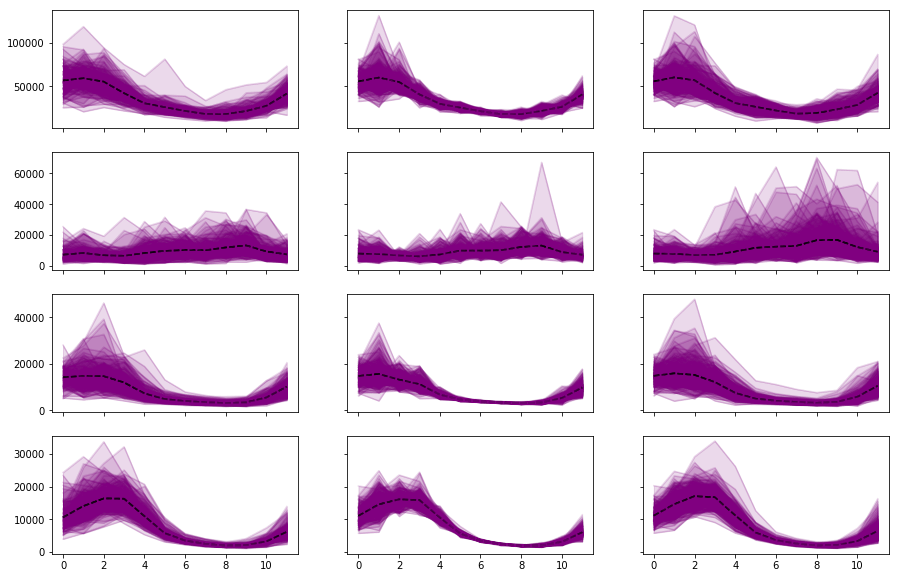

In [9]:
fig, ax = plt.subplots(4,3,figsize=(15,10), sharex=True, sharey='row')
for i in range(4):
    for j in range(3):
        fan_plot(hist[i].values, ax[i][0])
        fan_plot(a_wo_linearization[...,i], ax[i][1])
        fan_plot(a_w_linearization[...,i], ax[i][2])